# Description

Here we test the idea that there is some momentum in optimized portfolios: if yesterday's returns were "good", put on a larger position for tomorrow; if they were "bad", put on a smaller position for tomorrow.


# Conclusion

It appears to be of great benefit to implement some form of scaling. This should be investigated in the future.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from ram.analysis.run_manager import RunManagerGCP
from ram.analysis.combo_search import CombinationSearch
from ram.analysis.statistics import get_stats, rollup_returns

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
RunManagerGCP.get_run_names('StatArbStrategy2')

,Run,RunDate,Completed,Description,Starred
0,run_0001,2018-02-15,True,"Smart factor, sector 20",
1,run_0002,2018-02-15,True,"Smart factor, all sectors",
2,run_0003,2018-02-22,True,"New run with smart factor, sector 20",
3,run_0004,2018-02-20,False,"New run with smart factor, sector 25",
4,run_0005,2018-02-20,False,"New run with smart factor, sector 45",
5,run_0007,2018-02-23,True,"Sector 20, new params, more features for sort",
6,run_0009,2018-02-24,True,"Bayes, Sector 20",
7,run_0012,2018-02-28,True,"Sector20, mult",


In [3]:
run1 = RunManagerGCP('StatArbStrategy2', 'run_0007')

comb1 = CombinationSearch()
comb1.add_run(run1)
comb1.start(10, 'mean')

  0%|          | 0/1 [00:00<?, ?it/s]

Reading and aggregating runs...


  0%|          | 0/10 [00:00<?, ?it/s]

Finished aggregating runs...


100%|██████████| 10/10 [02:09<00:00, 10.23s/it]


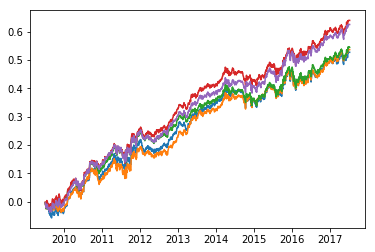

In [4]:
plt.figure()
plt.plot(comb1.best_results_rets.dropna().cumsum())
plt.show()

### Increase capital deployed if previous day was winner/loser

In [6]:
returns = comb1.best_results_rets.dropna()

In [28]:
def scale_returns(returns, top_thresh=0.002, bottom_thresh=-0.001, top_size=1.5, bottom_size=0.85):
    scaling = returns.copy()
    scaling[:] = 1

    # Shifted forward 1 day. In production, one would see how the day is going at 345, and adjust accordingly
    scaling[returns.shift(1) > top_thresh] = top_size
    scaling[returns.shift(1) < bottom_thresh] = bottom_size

    return returns * scaling

### Grid Search over different params

In [57]:
import itertools

top_thresh = [0.001, 0.002, 0.003]
bottom_thresh = [-0.000, -0.001, -0.002, -0.003, -0.004]
top_size = [1.2, 1.3, 1.4, 1.5]
bottom_size = [0.6, 0.7, 0.8, 0.9]

output = pd.DataFrame(columns=['TopThresh', 'BottomThresh', 'TopSize', 'BottomSize',
                               'TotalRet', 'Sharpe'])

for i, (t1, b1, t2, b2) in enumerate(itertools.product(top_thresh, bottom_thresh, top_size, bottom_size)):
    srets = scale_returns(returns, t1, b1, t2, b2)
    tot_ret = srets.sum().mean()
    sharpe = (srets.mean() / srets.std()).mean()
    output.loc[i, 'TopThresh'] = t1
    output.loc[i, 'BottomThresh'] = b1
    output.loc[i, 'TopSize'] = t2
    output.loc[i, 'BottomSize'] = b2
    output.loc[i, 'TotalRet'] = tot_ret
    output.loc[i, 'Sharpe'] = sharpe

output.TotalRet = output.TotalRet.astype(float)
output.Sharpe = output.Sharpe.astype(float)

In [58]:
output.head()

,TopThresh,BottomThresh,TopSize,BottomSize,TotalRet,Sharpe
0,0.001,-0,1.2,0.6,0.640936,0.084125
1,0.001,-0,1.2,0.7,0.645822,0.081856
2,0.001,-0,1.2,0.8,0.650709,0.079440
3,0.001,-0,1.2,0.9,0.655595,0.076948
4,0.001,-0,1.3,0.6,0.683577,0.084683


In [59]:
output.groupby('TopThresh')[['TotalRet', 'Sharpe']].mean()

,TotalRet,Sharpe
TopThresh,,
0.001,0.725861,0.081094
0.002,0.711596,0.081718
0.003,0.673670,0.079668


In [60]:
output.groupby('BottomThresh')[['TotalRet', 'Sharpe']].mean()

,TotalRet,Sharpe
BottomThresh,,
-0.004,0.705882,0.078998
-0.003,0.712027,0.080707
-0.002,0.703507,0.080675
-0.001,0.707055,0.082149
-0.000,0.690075,0.081604


In [61]:
output.groupby('TopSize')[['TotalRet', 'Sharpe']].mean()

,TotalRet,Sharpe
TopSize,,
1.2,0.649241,0.079509
1.3,0.685553,0.080509
1.4,0.721865,0.081319
1.5,0.758177,0.081969


In [62]:
output.groupby('BottomSize')[['TotalRet', 'Sharpe']].mean()

,TotalRet,Sharpe
BottomSize,,
0.6,0.704560,0.083603
0.7,0.703993,0.081829
0.8,0.703425,0.079931
0.9,0.702858,0.077944


### Plot top parameters

In [63]:
scaled_returns = scale_returns(returns, top_thresh=0.001, bottom_thresh=-0.003, top_size=1.5, bottom_size=0.9)

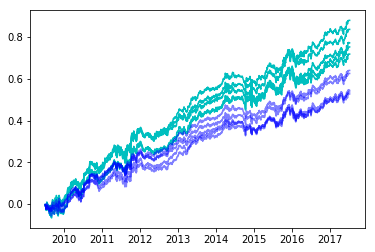

In [64]:
plt.figure()
plt.plot(scaled_returns.cumsum(), 'c')
plt.plot(returns.cumsum(), 'b', alpha=0.5)
plt.show()

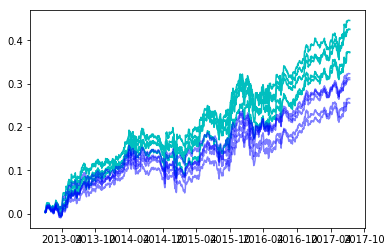

In [72]:
# Results since 2013
dates = scaled_returns.index[scaled_returns.index > pd.Timestamp('2013-01-01')]

plt.figure()
plt.plot(scaled_returns.loc[dates].cumsum(), 'c')
plt.plot(returns.loc[dates].cumsum(), 'b', alpha=0.5)
plt.show()

### Stats and rolled-up returns - Since 2013

In [78]:
dates = returns.index[returns.index > pd.Timestamp('2013-01-01')]

stats1 = get_stats(returns.loc[dates])
stats1

,0,1,2,3,4
Total,0.2659,0.3097,0.2555,0.3137,0.3233
Mean,0.0002,0.0003,0.0002,0.0003,0.0003
Std,0.0039,0.0039,0.0038,0.0038,0.0038
Skew,-0.0066,-0.0607,-0.0012,-0.0288,0.0542
Kurt,2.2300,2.4300,1.9600,2.0100,1.8200
Sharpe,0.9601,1.1043,0.9246,1.1599,1.1915
Sortino,1.6472,1.8883,1.5965,2.0020,2.0660
MinRet,-0.0183,-0.0196,-0.0187,-0.0174,-0.0162
WinP,0.5210,0.5254,0.5201,0.5289,0.5359
DD%,-0.0713,-0.0669,-0.0758,-0.0671,-0.0565


In [79]:
dates = scaled_returns.index[scaled_returns.index > pd.Timestamp('2013-01-01')]

stats2 = get_stats(scaled_returns.loc[dates])
stats2

,0,1,2,3,4
Total,0.3734,0.4254,0.3719,0.4461,0.4256
Mean,0.0003,0.0004,0.0003,0.0004,0.0004
Std,0.0047,0.0047,0.0047,0.0046,0.0046
Skew,0.1108,0.0279,0.1942,0.0987,0.0831
Kurt,2.6500,2.8600,2.9200,2.0900,2.4200
Sharpe,1.1057,1.2486,1.0973,1.3609,1.2916
Sortino,1.9187,2.1522,1.9300,2.3994,2.2392
MinRet,-0.0220,-0.0216,-0.0215,-0.0181,-0.0211
WinP,0.5210,0.5254,0.5201,0.5289,0.5359
DD%,-0.0867,-0.0833,-0.0858,-0.0711,-0.0706


In [84]:
# Non-Scaled
print stats1.loc['Sharpe']
print '\n\nMean Sharpe: ', stats1.loc['Sharpe'].mean()

0    0.9601
1    1.1043
2    0.9246
3    1.1599
4    1.1915
Name: Sharpe, dtype: float64


Mean Sharpe:  1.06808


In [85]:
# Scaled
print stats2.loc['Sharpe']
print '\n\nMean Sharpe: ', stats2.loc['Sharpe'].mean()

0    1.1057
1    1.2486
2    1.0973
3    1.3609
4    1.2916
Name: Sharpe, dtype: float64


Mean Sharpe:  1.22082


In [88]:
df = rollup_returns(returns)
df['Year'] = df.sum(axis=1)
df

Qtr,1,2,3,4,Year
Year,,,,,
2009,NaN,NaN,-0.040312,0.016159,-0.024153
2010,0.068816,-0.005065,0.070645,-0.013370,0.121027
2011,0.044237,0.011423,-0.017711,0.078239,0.116188
2012,-0.023788,-0.003973,0.019205,0.057194,0.048638
2013,-0.006856,0.051572,0.024483,0.016985,0.086184
2014,0.042699,-0.005395,-0.020146,-0.011250,0.005908
2015,0.013321,0.036602,-0.025292,0.072080,0.096711
2016,-0.005185,0.000361,0.007288,0.036665,0.039129
2017,0.017957,0.016503,0.003533,NaN,0.037994


In [89]:
df2 = rollup_returns(scaled_returns)
df2['Year'] = df2.sum(axis=1)
df2

Qtr,1,2,3,4,Year
Year,,,,,
2009,NaN,NaN,-0.038921,0.014675,-0.024245
2010,0.090780,-0.000811,0.077626,-0.026581,0.141014
2011,0.055348,0.023428,-0.008279,0.103753,0.174250
2012,-0.029954,-0.007343,0.023939,0.067580,0.054222
2013,-0.004382,0.066186,0.031516,0.016302,0.109621
2014,0.043165,0.005729,-0.018136,0.005602,0.036360
2015,0.020475,0.046427,-0.025738,0.096419,0.137582
2016,-0.025009,0.005574,0.006315,0.044781,0.031660
2017,0.022769,0.031758,0.003614,NaN,0.058140


In [97]:
# BENEFIT
benefit = df2 - df

print 'Yearly benefit:\n\n', benefit.mean(axis=1)
print '\n'
benefit

Yearly benefit:

Year
2009   -0.000061
2010    0.007995
2011    0.023225
2012    0.002234
2013    0.009375
2014    0.012181
2015    0.016348
2016   -0.002987
2017    0.010073
dtype: float64




Qtr,1,2,3,4,Year
Year,,,,,
2009,NaN,NaN,0.001392,-0.001484,-0.000092
2010,0.021963,0.004254,0.006981,-0.013212,0.019987
2011,0.011110,0.012005,0.009433,0.025514,0.058062
2012,-0.006166,-0.003370,0.004734,0.010386,0.005584
2013,0.002474,0.014614,0.007033,-0.000684,0.023438
2014,0.000466,0.011125,0.002010,0.016851,0.030452
2015,0.007154,0.009825,-0.000446,0.024338,0.040871
2016,-0.019824,0.005212,-0.000973,0.008116,-0.007469
2017,0.004811,0.015254,0.000081,NaN,0.020146
